In [5]:
using Pkg
Pkg.activate("..")

using SmallCouplingDynamicCavity
using Graphs, GraphRecipes
using Plots
using StatsBase, Random
using LaTeXStrings

  Activating project at `~/julia_codes/SmallCouplingDynamicCavity`
[ Info: Precompiling SmallCouplingDynamicCavity [1607259e-80f4-4675-b495-cb9c54bacb3f]


LoadError: importing SmallCouplingDynamicCavity into Main conflicts with an existing global

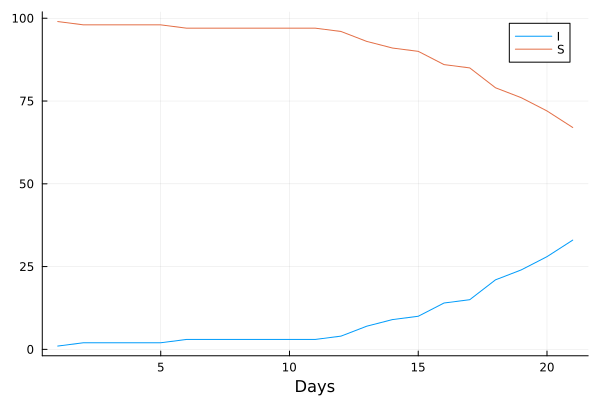

In [2]:
NV::Int = 100 # number of graph vertices
k::Int = 3 # degree

T::Int = 20 # total time
fₚ::Float64 = 0.0 # false-positive rate
fₙ::Float64 = 0.0 # false-negative rate
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.2 # Infection rate
ε_autoinf::Float64 = 1e-10 # Self-infection rate
Nobs::Int = ceil(NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64; fₚ::Float64 = fₚ, fₙ::Float64 = fₙ)
    if Ob == 0.0
        return (1-fₚ)*(1-x) + fₙ*x
    elseif  Ob == 1.0
        return fₚ*(1-x) + (1-fₙ)*x
    elseif Ob == -1.0
        return 1.0
    end
end

G = Vector{SimpleGraph{Int64}}()
λ = zeros(NV, NV, T+1)

for t in 1:T+1
    g = erdos_renyi(NV, k/NV)
    push!(G,g)
    for e in edges(g)
        λ[src(e), dst(e), t] = rand() * λ₀
        λ[dst(e), src(e), t] = rand() * λ₀
    end
end

# define de epidemic model
infectionmodel = SI(ε_autoinf, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(NV, T+1) * (-1.0)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
plot([nrS nrI], xlabel = "Days", ylabel = "", label = ["S" "I"])

In [4]:
# computational constants
epsconv::Float64 = 1e-5 # convergence threshold
maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.1 # damping factor
μ_cutoff::Float64 = -1.0 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report);

i = 1 ε = 0.9
i = 2 ε = 1.251197676988585
i = 3 ε = 0.44792205237095273
i = 4 ε = 0.39935936012395556
i = 5 ε = 0.2951703866516676
i = 6 ε = 0.08781595582177695
i = 7 ε = 0.0698973634513902
i = 8 ε = 0.02237944200247477
i = 9 ε = 0.025898191931801873
i = 10 ε = 0.00657539151258163
i = 11 ε = 0.006857792562537379
i = 12 ε = 0.0025506466975561692
i = 13 ε = 0.0018185148671171492
i = 14 ε = 0.0008555408548749366
i = 15 ε = 0.00037105875184656467
i = 16 ε = 0.00029131077596444843
i = 17 ε = 8.343663799648127e-5
i = 18 ε = 0.00010174163213161336
i = 19 ε = 2.9111720616148418e-5
i = 20 ε = 2.9349701232861403e-5
i = 21 ε = 1.0112693328401257e-5
i = 22 ε = 8.126694146015634e-6
Converged after 22 iterations
